### Import Library

In [ ]:
!pip install symspellpy
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from symspellpy import SymSpell, Verbosity
import pkg_resources
import spacy
import nlpaug.augmenter.word as naw
from nlpaug.augmenter.word import ContextualWordEmbsAug

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-2-5da687643c1d>:22: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/TEXT MINING/Dataset/emotions.csv')
df

text  label
0           i just feel really helpless and heavy hearted      4
1       ive enjoyed being able to slouch about relax a...      0
2       i gave up my internship with the dmrg and am f...      4
3                              i dont know i feel so lost      0
4       i am a kindergarten teacher and i am thoroughl...      4
...                                                   ...    ...
416804  i feel like telling these horny devils to find...      2
416805  i began to realize that when i was feeling agi...      3
416806  i feel very curious be why previous early dawn...      5
416807  i feel that becuase of the tyranical nature of...      3
416808  i think that after i had spent some time inves...      5

[416809 rows x 2 columns]

In [ ]:
example_emotions = df.groupby('label').first().reset_index()
example_emotions[['text', 'label']]

text  label
0  ive enjoyed being able to slouch about relax a...      0
1  i fear that they won t ever feel that deliciou...      1
2  i would think that whomever would be lucky eno...      2
3  i feel like a jerk because the library student...      3
4      i just feel really helpless and heavy hearted      4
5  im forever taking some time out to have a lie ...      5

In [ ]:
df.shape

(416809, 2)

In [ ]:
df['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


# Data Cleaning

### Handling Missing & Duplicate Values

In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
df.duplicated().sum()

686

In [ ]:
df = df.drop_duplicates()

### Basic Noise Cleansing

In [ ]:
def clean_basic_noise(text):
    text = text.lower()
    text = text.encode('ascii', 'ignore').decode('ascii')  # Remove emoji
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

Walaupun teks di dataset kelihatannya udah bersih, proses cleansing tetap kami lakuin buat jaga-jaga. Biar nggak ada yang nyempil kayak URL, emoji, tanda baca, atau hal-hal ngga penting lainnya, jadi datanya bener-bener siap dipakai buat analisis.

In [ ]:
df['cleaned_text'] = df['text'].apply(clean_basic_noise)
df[['text', 'cleaned_text']].head()

<ipython-input-18-3260999bb149>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['text'].apply(clean_basic_noise)


text  \
0      i just feel really helpless and heavy hearted   
1  ive enjoyed being able to slouch about relax a...   
2  i gave up my internship with the dmrg and am f...   
3                         i dont know i feel so lost   
4  i am a kindergarten teacher and i am thoroughl...   

                                        cleaned_text  
0      i just feel really helpless and heavy hearted  
1  ive enjoyed being able to slouch about relax a...  
2  i gave up my internship with the dmrg and am f...  
3                         i dont know i feel so lost  
4  i am a kindergarten teacher and i am thoroughl...

### Spelling Correction

In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=1)

True

In [ ]:
def correct_spelling_symspell(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    if suggestions:
        return suggestions[0].term
    return text

In [ ]:
df['corrected_spelling'] = df['cleaned_text'].apply(correct_spelling_symspell)
df[['cleaned_text', 'corrected_spelling']].head()

<ipython-input-21-5dd8f76ab7b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['corrected_spelling'] = df['cleaned_text'].apply(correct_spelling_symspell)


cleaned_text  \
0      i just feel really helpless and heavy hearted   
1  ive enjoyed being able to slouch about relax a...   
2  i gave up my internship with the dmrg and am f...   
3                         i dont know i feel so lost   
4  i am a kindergarten teacher and i am thoroughl...   

                                  corrected_spelling  
0      i just feel really helpless and heavy hearted  
1  live enjoyed being able to slouch about relax ...  
2  i gave up my internship with the drug and am f...  
3                         i done know i feel so lost  
4  i am a kindergarten teacher and i am thoroughl...

Kami menggunakan SymSpell buat benerin typo atau salah ejaan di teks. Jadi, dia ngecek tiap kata pake kamus kata dan bigram buat ngasih saran yang paling cocok sesuai konteks. Fungsi correct_spelling_symspell bakal ngembaliin teks yang udah diperbaiki, atau tetep teks aslinya kalo nggak ada typo yang perlu dibenerin.

In [ ]:
output_file = '/content/drive/My Drive/TEXT MINING/Dataset/emotions_corrected_spelling.csv'
df[['corrected_spelling', 'label']].to_csv(output_file, index=False)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/TEXT MINING/Dataset/emotions_corrected_spelling.csv')
df.head(10)

corrected_spelling  label
0      i just feel really helpless and heavy hearted      4
1  live enjoyed being able to slouch about relax ...      0
2  i gave up my internship with the drug and am f...      4
3                         i done know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4
5         i was beginning to feel quite disheartened      0
6  i would think that whomever would be lucky eno...      2
7  i fear that they wont ever feel that delicious...      1
8  in forever taking some time out to have a lie ...      5
9  i can still lose the weight without feeling de...      0

### 1st StopWords Removal

In [ ]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [ ]:
df['stopword_removal_1'] = df['corrected_spelling'].apply(remove_stopwords)
df[['corrected_spelling', 'stopword_removal_1']].head()

corrected_spelling  \
0      i just feel really helpless and heavy hearted   
1  live enjoyed being able to slouch about relax ...   
2  i gave up my internship with the drug and am f...   
3                         i done know i feel so lost   
4  i am a kindergarten teacher and i am thoroughl...   

                                  stopword_removal_1  
0                 feel really helpless heavy hearted  
1  live enjoyed able slouch relax unwind frankly ...  
2            gave internship drug feeling distraught  
3                                done know feel lost  
4  kindergarten teacher thoroughly weary job take...

Setelah spelling correction, kami melakukan stop word removal untuk menghapus kata-kata umum yang tidak memiliki makna signifikan, seperti "the", "is", atau "and", sehingga teks lebih fokus pada kata-kata penting untuk analisis.

### Lemmatization

In [ ]:
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatizer(text):
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(lemmatized)

In [ ]:
df['lemmatized_text'] = df['stopword_removal_1'].apply(spacy_lemmatizer)
df[['stopword_removal_1', 'lemmatized_text']].head(10)

stopword_removal_1  \
0                 feel really helpless heavy hearted   
1  live enjoyed able slouch relax unwind frankly ...   
2            gave internship drug feeling distraught   
3                                done know feel lost   
4  kindergarten teacher thoroughly weary job take...   
5                  beginning feel quite disheartened   
6  would think whomever would lucky enough stay s...   
7  fear wont ever feel delicious excitement chris...   
8                 forever taking time lie feel weird   
9         still lose weight without feeling deprived   

                                     lemmatized_text  
0                        feel helpless heavy hearted  
1  live enjoy able slouch relax unwind frankly ne...  
2            give internship drug feeling distraught  
3                                     know feel lost  
4  kindergarten teacher thoroughly weary job take...  
5                            begin feel disheartened  
6  think whomever lucky stay suite feel like roma...  
7  fear will not feel delicious excitement christ...  
8                   forever take time lie feel weird  
9                           lose weight feel deprive

Setelah stop word removal, proses dilanjutkan dengan **lemmatization** menggunakan SpaCy. Lemmatization digunakan untuk mengubah kata ke bentuk dasarnya (lemma), seperti mengubah "running" menjadi "run", sehingga mengurangi variasi kata tanpa kehilangan makna. Ini membantu menyederhanakan teks dan meningkatkan konsistensi untuk analisis lebih lanjut.

In [ ]:
output_file = '/content/drive/My Drive/TEXT MINING/Dataset/emotions_lemmatization.csv'
df[['lemmatized_text', 'label']].to_csv(output_file, index=False)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/TEXT MINING/Dataset/emotions_lemmatization.csv')
df.head(10)

lemmatized_text  label
0                        feel helpless heavy hearted      4
1  live enjoy able slouch relax unwind frankly ne...      0
2            give internship drug feeling distraught      4
3                                     know feel lost      0
4  kindergarten teacher thoroughly weary job take...      4
5                            begin feel disheartened      0
6  think whomever lucky stay suite feel like roma...      2
7  fear will not feel delicious excitement christ...      1
8                   forever take time lie feel weird      5
9                           lose weight feel deprive      0

### 2nd StopWords Removal

In [ ]:
df['lemmatized_text'].dtypes

dtype('O')

In [ ]:
df['lemmatized_text'] = df['lemmatized_text'].fillna('').astype(str)

In [ ]:
df['stopword_removal_2'] = df['lemmatized_text'].apply(remove_stopwords)
df[['lemmatized_text', 'stopword_removal_2']].head(10)

lemmatized_text  \
0                        feel helpless heavy hearted   
1  live enjoy able slouch relax unwind frankly ne...   
2            give internship drug feeling distraught   
3                                     know feel lost   
4  kindergarten teacher thoroughly weary job take...   
5                            begin feel disheartened   
6  think whomever lucky stay suite feel like roma...   
7  fear will not feel delicious excitement christ...   
8                   forever take time lie feel weird   
9                           lose weight feel deprive   

                                  stopword_removal_2  
0                        feel helpless heavy hearted  
1  live enjoy able slouch relax unwind frankly ne...  
2            give internship drug feeling distraught  
3                                     know feel lost  
4  kindergarten teacher thoroughly weary job take...  
5                            begin feel disheartened  
6  think whomever lucky stay suite feel like roma...  
7  fear feel delicious excitement christmas eve w...  
8                   forever take time lie feel weird  
9                           lose weight feel deprive

Di sini, kami melakukan **stop word removal** tahap kedua setelah lemmatization untuk memastikan bahwa stop words yang mungkin muncul kembali dalam bentuk dasar (setelah lemmatization) juga terhapus. Langkah ini membantu teks menjadi lebih bersih dan fokus hanya pada kata-kata yang benar-benar relevan.

In [ ]:
df.rename(columns={'stopword_removal_2': 'preprocessed_text'}, inplace=True)

In [ ]:
output_file = '/content/drive/My Drive/TEXT MINING/Dataset/preprocessed_emotions.csv'
df[['preprocessed_text', 'label']].to_csv(output_file, index=False)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/TEXT MINING/Dataset/preprocessed_emotions.csv')
df.head(10)

preprocessed_text  label
0                        feel helpless heavy hearted      4
1  live enjoy able slouch relax unwind frankly ne...      0
2            give internship drug feeling distraught      4
3                                     know feel lost      0
4  kindergarten teacher thoroughly weary job take...      4
5                            begin feel disheartened      0
6  think whomever lucky stay suite feel like roma...      2
7  fear feel delicious excitement christmas eve w...      1
8                   forever take time lie feel weird      5
9                           lose weight feel deprive      0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416101 entries, 0 to 416100
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   preprocessed_text  416101 non-null  object
 1   label              416101 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.3+ MB


# Data Splitting

In [ ]:
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['label'])

print(f"Training set: {len(train_data)} entries")
print(f"Validation set: {len(val_data)} entries")
print(f"Testing set: {len(test_data)} entries")

Training set: 332880 entries
Validation set: 41610 entries
Testing set: 41611 entries


Karena datanya banyak, pembagian dilakukan dengan proporsi 80:10:10 untuk training, validation, dan testing. Kami menggunakan **stratify sampling** supaya distribusi label di setiap set tetap seimbang, sehingga model dapat belajar dan diuji dengan representasi yang konsisten dari dataset.

In [ ]:
train_data['label'].value_counts()

label
1    112620
0     96787
3     45781
4     38127
2     27598
5     11967
Name: count, dtype: int64

In [ ]:
val_data['label'].value_counts()

label
1    14078
0    12098
3     5722
4     4766
2     3450
5     1496
Name: count, dtype: int64

In [ ]:
test_data['label'].value_counts()

label
1    14078
0    12099
3     5723
4     4766
2     3449
5     1496
Name: count, dtype: int64

In [ ]:
train_data.to_csv('/content/drive/My Drive/TEXT MINING/Dataset/train_data.csv', index=False)
val_data.to_csv('/content/drive/My Drive/TEXT MINING/Dataset/val_data.csv', index=False)
test_data.to_csv('/content/drive/My Drive/TEXT MINING/Dataset/test_data.csv', index=False)

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/TEXT MINING/Dataset/train_data.csv')
val_data = pd.read_csv('/content/drive/My Drive/TEXT MINING/Dataset/val_data.csv')
test_data = pd.read_csv('/content/drive/My Drive/TEXT MINING/Dataset/test_data.csv')

# Data Visualization

### Label Distribution

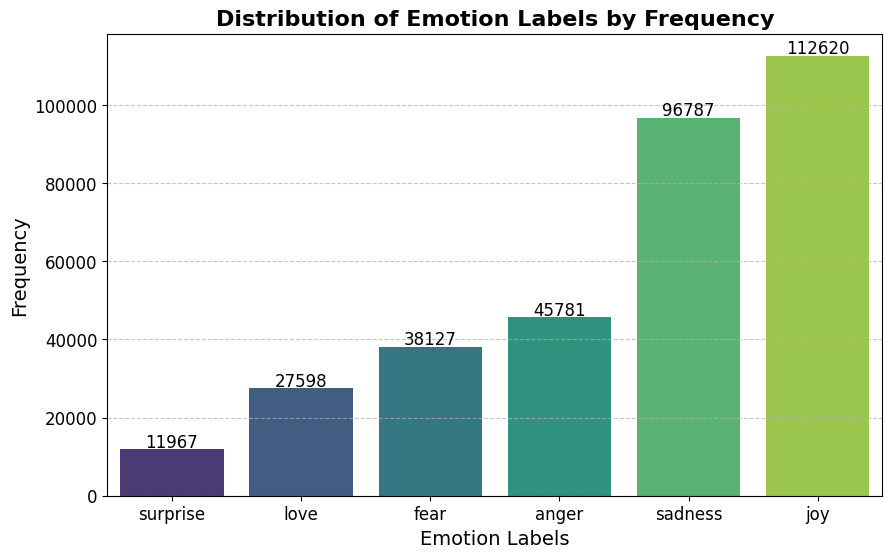

In [ ]:
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

label_counts = train_data['label'].value_counts()

label_counts = label_counts.reset_index()
label_counts.columns = ['label', 'count']
label_counts['emotion'] = label_counts['label'].map(label_mapping)
label_counts = label_counts.sort_values(by='count', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts['emotion'], y=label_counts['count'], palette="viridis")
plt.title('Distribution of Emotion Labels by Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Emotion Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(label_counts['count']):
    plt.text(i, count + 500, str(count), ha='center', fontsize=12)

plt.show()

Grafik ini menunjukkan distribusi label emosi yang tidak merata. Label joy (1) memiliki jumlah sampel terbanyak, mencapai sekitar 112 ribu, sedangkan label surprise (5) adalah yang paling sedikit, hanya sekitar 12 ribu. Label lainnya, seperti sadness (0), anger (3), fear (4), dan love (2), berada di antara kedua ekstrem tersebut dengan jumlah yang bervariasi.

### Text Length Analysis

In [ ]:
train_data['word_count'] = train_data['preprocessed_text'].apply(lambda x: len(x.split()))
train_data['char_count'] = train_data['preprocessed_text'].apply(len)

average_word_count = train_data['word_count'].mean()
median_word_count = train_data['word_count'].median()

average_char_count = train_data['char_count'].mean()
median_char_count = train_data['char_count'].median()

print(f"Average Word Count: {average_word_count:.2f}")
print(f"Median Word Count: {median_word_count:.2f}")
print(f"Average Character Count: {average_char_count:.2f}")
print(f"Median Character Count: {median_char_count:.2f}")

Average Word Count: 7.86
Median Word Count: 7.00
Average Character Count: 49.84
Median Character Count: 43.00


Dari analisis panjang teks ini, terlihat bahwa sebagian besar sampel dalam dataset memiliki panjang yang relatif pendek, baik dari segi jumlah kata maupun jumlah karakter. Rata-rata teks hanya memiliki **sekitar 7-8 kata** dengan median 7 kata, sedangkan untuk jumlah karakter rata-rata sekitar **50 karakter** dengan median 43 karakter.

In [ ]:
max_len_train = train_data['preprocessed_text'].str.split().str.len().max()
print(max_len_train)

max_len_test = test_data['preprocessed_text'].str.split().str.len().max()
print(max_len_test)

max_len_val = val_data['preprocessed_text'].str.split().str.len().max()
print(max_len_val)

max_sequence_length = max(max_len_train, max_len_test, max_len_val)
print("\nMax Sequence Length:")
print(max_sequence_length)

66
38
39

Max Sequence Length:
66


Sequenct length terpanjang nanti akan digunakan untuk menentukan max length pada saat padding di Word2Vec maupun GloVe

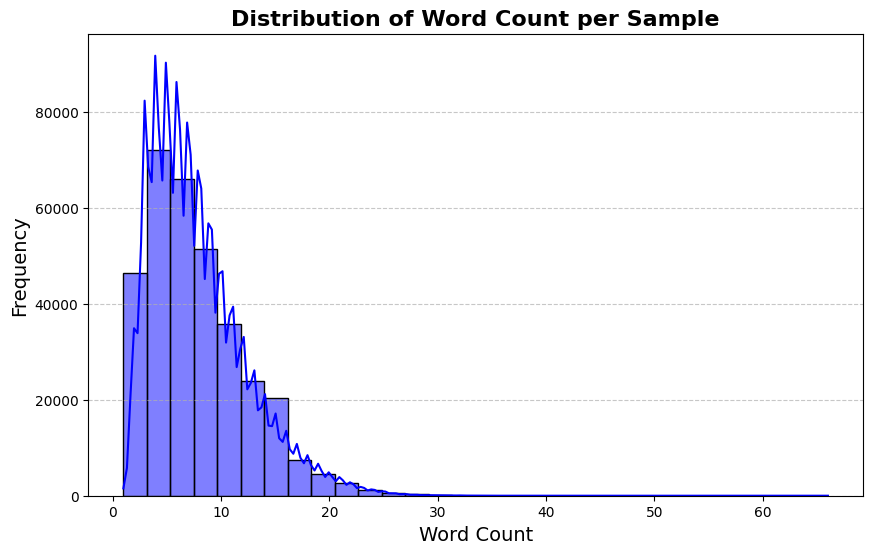

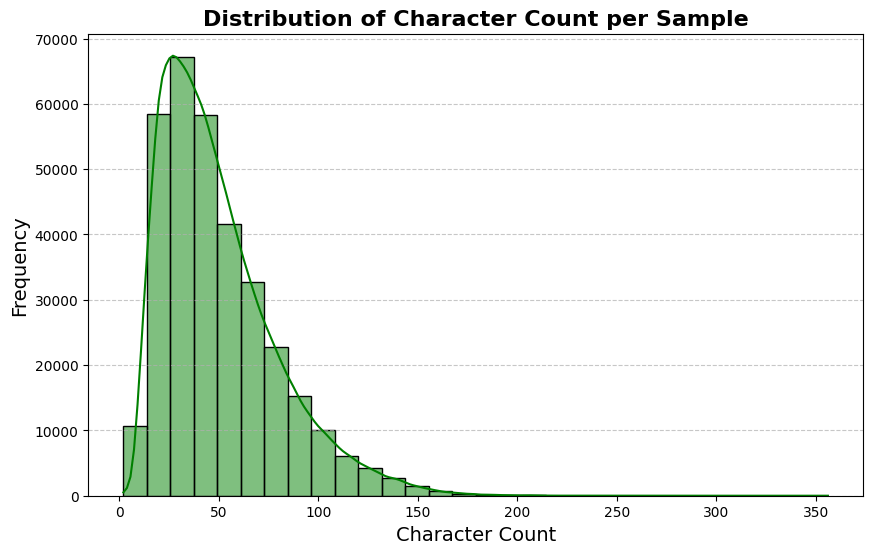

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of Word Count per Sample', fontsize=16, fontweight='bold')
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(train_data['char_count'], bins=30, kde=True, color='green')
plt.title('Distribution of Character Count per Sample', fontsize=16, fontweight='bold')
plt.xlabel('Character Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Distribusi ini menunjukkan sebagian besar teks memiliki panjang pendek. Pola ini mencerminkan bahwa sebagian besar teks sederhana dan tidak terlalu panjang, dengan hanya sedikit teks yang lebih panjang sebagai outlier.

### Common Words and N-Grams Analysis

In [ ]:
def get_top_ngrams(corpus, n=1, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(corpus)
    ngram_counts = ngrams.sum(axis=0).A1
    ngram_names = vectorizer.get_feature_names_out()
    ngram_df = pd.DataFrame({'ngram': ngram_names, 'count': ngram_counts})
    ngram_df = ngram_df.sort_values(by='count', ascending=False).head(top_k)
    return ngram_df

emotion_groups = train_data.groupby('label')

for label, group in emotion_groups:
    emotion_name = label_mapping[label]
    print(f"\n----- {emotion_name.upper()} ({label}) -----")

    print(f"\nTop Words for {emotion_name.capitalize()}:")
    top_words = get_top_ngrams(group['preprocessed_text'], n=1, top_k=10)
    print(top_words)

    print(f"\nTop 2-grams for {emotion_name.capitalize()}:")
    top_bigrams = get_top_ngrams(group['preprocessed_text'], n=2, top_k=10)
    print(top_bigrams)

    print(f"\nTop 3-grams for {emotion_name.capitalize()}:")
    top_trigrams = get_top_ngrams(group['preprocessed_text'], n=3, top_k=10)
    print(top_trigrams)

    print(f"\nTop 4-grams for {emotion_name.capitalize()}:")
    top_trigrams = get_top_ngrams(group['preprocessed_text'], n=4, top_k=10)
    print(top_trigrams)

    print(f"\nTop 5-grams for {emotion_name.capitalize()}:")
    top_trigrams = get_top_ngrams(group['preprocessed_text'], n=5, top_k=10)
    print(top_trigrams)


----- SADNESS (0) -----

Top Words for Sadness:
         ngram  count
6782      feel  97251
10817     like  17921
6785   feeling   7683
10366     know   6824
18881     time   6170
20428     want   5678
10911     live   5120
18757    think   5049
10905   little   4595
4508       day   4381

Top 2-grams for Sadness:
              ngram  count
93691     feel like  12024
93709   feel little   2718
92147      feel bit   1930
94264   feel pretty   1495
249713   start feel   1354
144998    know feel   1209
167740    make feel   1127
92081      feel bad   1107
93216   feel guilty   1028
217488     ref help   1020

Top 3-grams for Sadness:
                       ngram  count
133494        feel like miss    439
133418        feel like live    438
133745      feel like punish    427
326769          ref help wow    353
134614       feel little bit    249
134210  feel like ungrateful    195
132937        feel like doom    193
133047        feel like fake    191
133429        feel like lose    179


Dengan **n-gram = 5**, walaupun tidak benar-benar menggambarkan emotion, tetapi pola spesifik dan frasa khas yang membedakan setiap emosi mulai terlihat, seperti:

- **Sadness**: "target blank ref help wow"
- **Joy**: "happy feeling glad sunshine bag"
- **Love**: "leave skin feel lovely soft"
- **Anger**: "greedy jaws death chance pull"
- **Fear**: "wall disappear surround fear unprotected"
- **Surprise**: feel shocked dancing screen ilea"

Pola ini muncul karena konteks yang lebih kompleks baru dapat ditangkap pada n-gram yang lebih panjang. Oleh karena itu, **window size = 5** pada Word2Vec ideal untuk menangkap hubungan kata dan mencerminkan pola khas setiap emosi.

**Intinya:** **n-gram 5 mengungkap pola unik dari semua emosi, sehingga Word2Vec dengan window size = 5 adalah pilihan yang tepat.**

### Word Frequency

In [ ]:
train_data['tokens'] = train_data['preprocessed_text'].apply(lambda x: x.split())
all_tokens = [token for tokens in train_data['tokens'] for token in tokens]
word_counts = Counter(all_tokens)
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

word_frequency_df = pd.DataFrame(sorted_word_counts, columns=["Word", "Frequency"])
word_frequency_df

Word  Frequency
0           feel     334297
1           like      61256
2        feeling      22861
3           know      22655
4           want      20758
...          ...        ...
33954     scapes          1
33955       alts          1
33956  herbalism          1
33957    studies          1
33958      undid          1

[33959 rows x 2 columns]

In [ ]:
words_with_frequency_1 = word_frequency_df[word_frequency_df["Frequency"] == 1]
words_with_frequency_1

Word  Frequency
24399  defeatist          1
24400    pinhole          1
24401     onside          1
24402   aviation          1
24403     skirts          1
...          ...        ...
33954     scapes          1
33955       alts          1
33956  herbalism          1
33957    studies          1
33958      undid          1

[9560 rows x 2 columns]

Terdapat total 9.560 kata yang frekuensi kemunculannya hanya sekali, yang kemungkinan besar tidak memiliki makna signifikan dalam analisis. Kata-kata ini juga bisa saja merupakan hasil typo atau kesalahan lain. Oleh karena itu, untuk melatih Word2Vec, nilai **min_count=2** dipilih agar hanya kata-kata yang lebih relevan dan sering muncul yang disertakan dalam model.

In [ ]:
words_with_frequency_2 = word_frequency_df[word_frequency_df["Frequency"] == 2]
words_with_frequency_2

Word  Frequency
19868         yearned          2
19869          floras          2
19870     freemasonry          2
19871           crise          2
19872          briggs          2
...               ...        ...
24394          meagan          2
24395        breastfe          2
24396         noodles          2
24397  constructivism          2
24398         moulder          2

[4531 rows x 2 columns]

### WordClouds

Generating word cloud for the Train dataset...


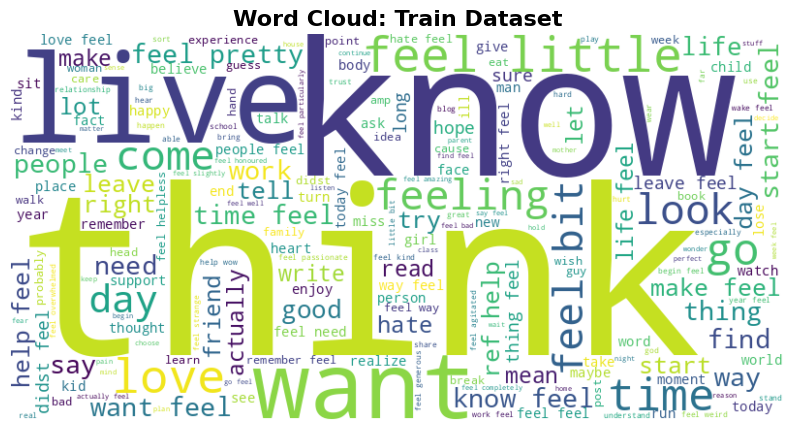

In [ ]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        repeat=False
    ).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.show()

all_text = " ".join(train_data['preprocessed_text'])

print("Generating word cloud for the Train dataset...")
generate_wordcloud(all_text, "Word Cloud: Train Dataset")

Word cloud ini memberikan gambaran kata-kata yang paling sering muncul di seluruh dataset. Kata **"feel"**, **"think"**, **"know"**, dan **"live"** sangat dominan, menunjukkan bahwa orang sering menggunakan kata-kata ini untuk mengekspresikan perasaan atau pandangan mereka. Frasa seperti **"want"**, **"love"**, dan **"time"** juga muncul cukup sering, yang menyoroti tema umum terkait keinginan, emosi positif, dan konteks waktu. Word cloud ini menegaskan bahwa dataset berfokus pada ekspresi perasaan dan pikiran, cocok untuk analisis emosi dan sentimen.

Generating word cloud for Sadness...


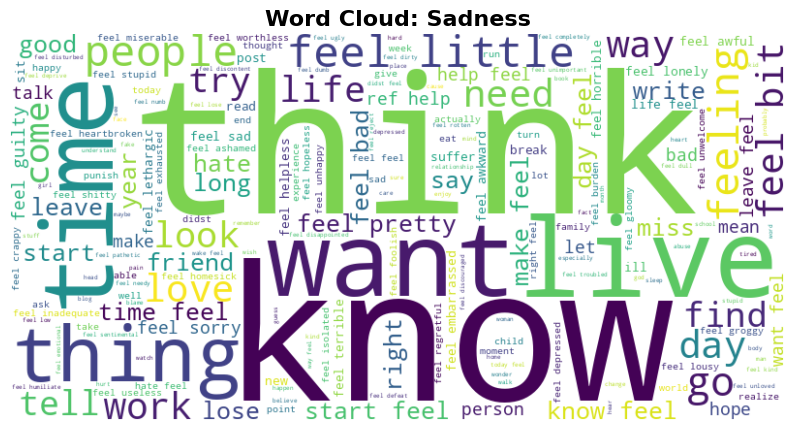

Generating word cloud for Joy...


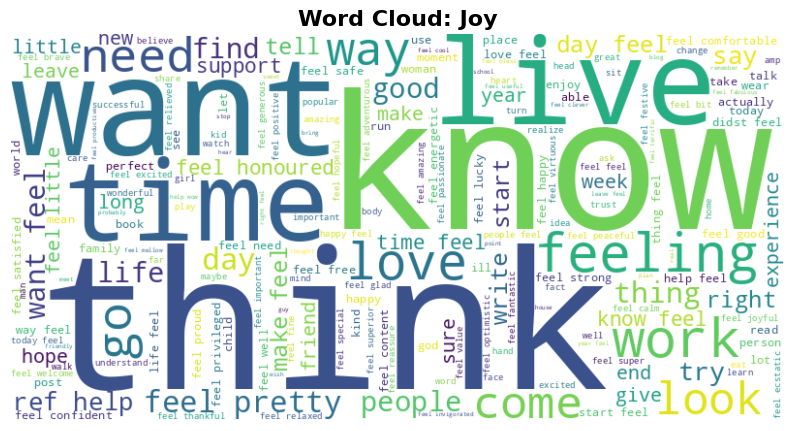

Generating word cloud for Love...


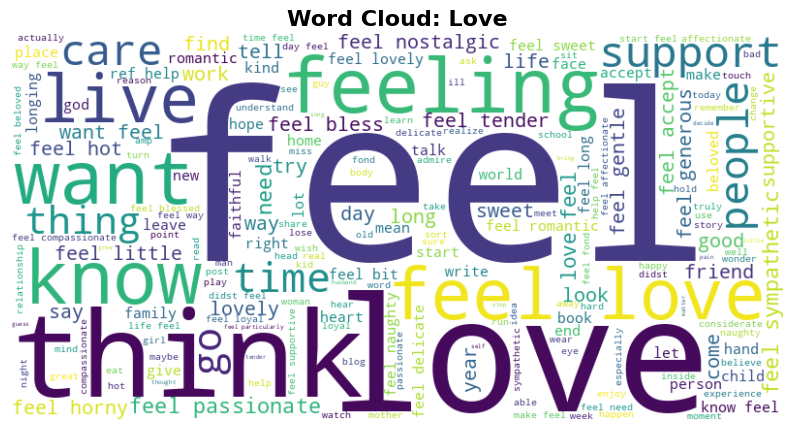

Generating word cloud for Anger...


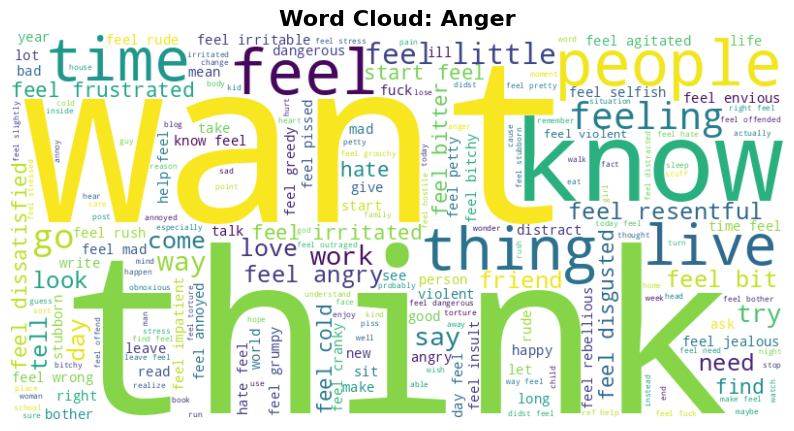

Generating word cloud for Fear...


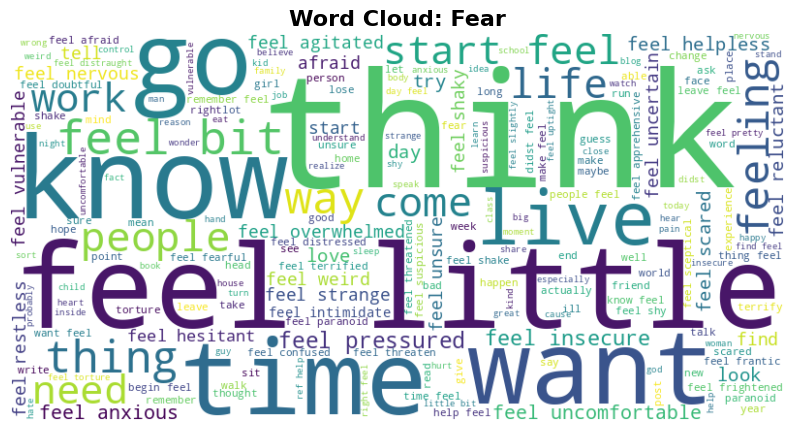

Generating word cloud for Surprise...


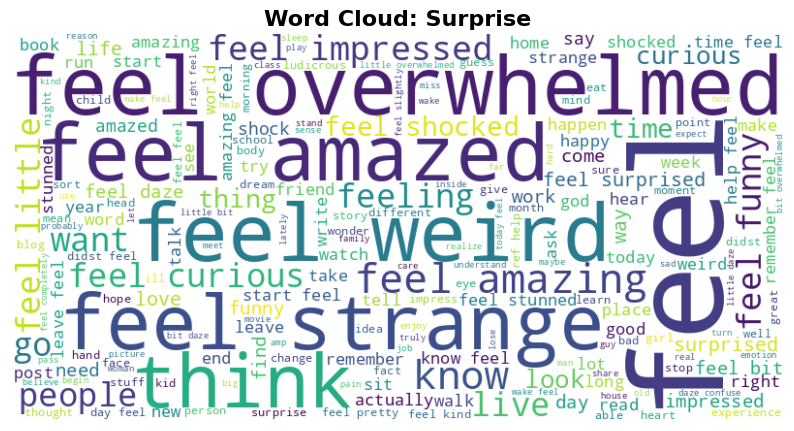

In [ ]:
for label, group in train_data.groupby('label'):
    emotion_name = label_mapping[label]
    text = " ".join(group['preprocessed_text'])
    print(f"Generating word cloud for {emotion_name.capitalize()}...")
    generate_wordcloud(text, f"Word Cloud: {emotion_name.capitalize()}")

### Outlier Detections

In [ ]:
train_data['word_count'] = train_data['preprocessed_text'].apply(lambda x: len(x.split()))
train_data['char_count'] = train_data['preprocessed_text'].apply(len)

train_data['punctuation_count'] = train_data['preprocessed_text'].apply(lambda x: sum([1 for char in x if char in string.punctuation]))

word_count_stats = train_data['word_count'].describe()
char_count_stats = train_data['char_count'].describe()
punctuation_stats = train_data['punctuation_count'].describe()

def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

word_count_lower, word_count_upper = detect_outliers(train_data, 'word_count')
outliers_word_count = train_data[(train_data['word_count'] < word_count_lower) | (train_data['word_count'] > word_count_upper)]

char_count_lower, char_count_upper = detect_outliers(train_data, 'char_count')
outliers_char_count = train_data[(train_data['char_count'] < char_count_lower) | (train_data['char_count'] > char_count_upper)]

punctuation_lower, punctuation_upper = detect_outliers(train_data, 'punctuation_count')
outliers_punctuation = train_data[(train_data['punctuation_count'] < punctuation_lower) | (train_data['punctuation_count'] > punctuation_upper)]

print(f"Word Count Outliers: {len(outliers_word_count)} entries")
print(f"Character Count Outliers: {len(outliers_char_count)} entries")

Word Count Outliers: 12675 entries
Character Count Outliers: 9408 entries


Hasil ini menunjukkan bahwa ada **12.675 teks** dengan jumlah kata yang sangat rendah atau sangat tinggi (**outliers**) dan **9.408 teks** dengan jumlah karakter yang berada di luar rentang normal, berdasarkan metode **IQR**. Outliers ini adalah teks yang dianggap ekstrem dalam panjang kata atau karakter.

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Boxplot of Word Count", "Boxplot of Character Count"))

fig.add_trace(
    go.Box(
        x=train_data['word_count'],
        name="Word Count",
        marker_color='blue'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Box(
        x=train_data['char_count'],
        name="Character Count",
        marker_color='green'
    ),
    row=1, col=2
)

fig.update_layout(
    title_font=dict(size=18),
    showlegend=False,
    template='plotly_white'
)

fig.update_xaxes(title_text="Word Count", row=1, col=1)
fig.update_xaxes(title_text="Character Count", row=1, col=2)

fig.show()

In [ ]:
print("\nExample Word Count Outliers:")
outliers_word_count[['preprocessed_text', 'word_count']].head()


Example Word Count Outliers:


preprocessed_text  word_count
12  pleasing photograph come later post give drama...          19
19  doubt people deny easy fall co dependant habit...          18
28  like book set specific time place peace love m...          18
63  feel inside life like game come wall disappear...          19
92  interested historical role freemasonry fatheri...          23

In [ ]:
print("\nExample Character Count Outliers:")
outliers_char_count[['preprocessed_text', 'char_count']].head()


Example Character Count Outliers:


preprocessed_text  char_count
9    continue offer open surgery particularly affor...         136
12   pleasing photograph come later post give drama...         136
19   doubt people deny easy fall co dependant habit...         126
92   interested historical role freemasonry fatheri...         180
108  truly feel lords tender mercy moment discourag...         137

Dalam konteks data teks emosi, outliers dipertahankan karena teks dengan panjang yang tidak biasa bisa merepresentasikan ekspresi emosi yang lebih kompleks atau unik, yang mungkin menjadi pola penting dalam klasifikasi emosi. Selain itu, keragaman panjang teks mencerminkan variasi cara orang mengekspresikan emosi mereka, baik melalui teks pendek yang langsung maupun teks panjang yang lebih mendalam. Menghapus outliers dapat menyebabkan hilangnya informasi penting yang dapat memengaruhi performa model dalam memahami seluruh spektrum ekspresi emosi. Oleh karena itu, outliers ini dipertahankan untuk menjaga integritas data dan memastikan model dapat belajar dari seluruh variasi dalam dataset.